* For v2, I removed rare publishers b/c I had too many features(words) due to weird languages
* (25241, 24391). Too many features. Use PCA.
* For specify max & min number of occurence in vectorization step
* Perform clustering on LSA comps, and not NMF.
    * LSA and NMF are dense linear combinations & Clustering makes sense
    * NMF forces coef to be all positive (lose info) & not fit for clustering
    * LSA is unconstrained & can have negative coef & fit for clustering. Faster than NMF
* Do sentiment analysis
    * Add Vader and TextBlob
* CoreEx

# Resources

Algorithm
* [PCA with Text](https://github.com/silvernine209/nyc19_ds20/blob/master/curriculum/project-04/svd-pca/PCA_with_text_ex.ipynb)  
* [Guided LDA](https://www.freecodecamp.org/news/how-we-changed-unsupervised-lda-to-semi-supervised-guidedlda-e36a95f3a164/)

Scraping
* [Scrape Reddit Using API](https://towardsdatascience.com/scraping-reddit-data-1c0af3040768)  
* [Google Search Operators](https://ahrefs.com/blog/google-advanced-search-operators/)

API
* [CryptoCompare](https://www.cryptocompare.com)

MongoDB & AWS
* [Allow Python to connect to MongoDB on AWS](https://github.com/silvernine209/nyc19_ds20/blob/master/curriculum/project-04/mongodb-prep/python_to_aws_mongo_setup.md) 
* [MongoDB Exercises](https://github.com/silvernine209/nyc19_ds20/tree/master/curriculum/project-04/mongodb-lab)

Cryptocurrency
* [Bitcoin Transaction Time](https://themoneymongers.com/bitcoin-transaction-time/) ~ 10 min  
* [Crypto Sentiment Analysis Guide #1](https://hackernoon.com/sentiment-analysis-in-cryptocurrency-9abb40005d15)
* [Bitcoin Graph](https://www.coindesk.com/price/bitcoin)

Additional Support
* [NLP Resources](https://github.com/stepthom/text_mining_resources)  
* [Practitioner's NLP Guide](https://towardsdatascience.com/a-practitioners-guide-to-natural-language-processing-part-i-processing-understanding-text-9f4abfd13e72)
* [Metis Project 4 Folder](https://github.com/silvernine209/nyc19_ds20/tree/master/curriculum/project-04)  
* [Udacity Project Customer Segmentation](https://github.com/silvernine209/Udacity-Projects/blob/master/Segment%20Customers/customer_segments.ipynb)

Paper Trading
* [Alpaca](https://app.alpaca.markets/signup)
* [QuantConnect](https://www.quantconnect.com)

Visualization
* [Kim's Matplotlib](https://towardsdatascience.com/simple-ways-to-improve-your-matplotlib-b64eebccfd5)

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words". For example:

**max_df** = 0.50 means "ignore terms that appear in more than 50% of the documents".
**max_df** = 25 means "ignore terms that appear in more than 25 documents".
The default **max_df** is 1.0, which means "ignore terms that appear in more than 100% of the documents". Thus, the default setting does not ignore any terms.

**min_df** is used for removing terms that appear too infrequently. For example:


**min_df** = 0.01 means "ignore terms that appear in less than 1% of the documents".
**min_df** = 5 means "ignore terms that appear in less than 5 documents".
The default **min_df** is 1, which means "ignore terms that appear in less than 1 document". Thus, the default setting does not ignore any terms.


# Import Libraries

In [2]:
# Web Scraping
from bs4 import BeautifulSoup
from lxml import html
import requests


# NLP
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from contractions import CONTRACTION_MAP
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.tokenize import word_tokenize
# nltk.download('punkt')
from nltk.tokenize import MWETokenizer # multi-word expression
from nltk.tag import pos_tag
# nltk.download('averaged_perceptron_tagger')
# nltk.download('tagsets')

from gensim import corpora, models, similarities, matutils
import spacy
#python -m spacy download en_core_web_md
import en_core_web_md
import langdetect
nlp = en_core_web_md.load(parse=True, tag=True, entity=True)
tokenizer = ToktokTokenizer()
#nltk.download('stopwords')
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list+=['crypto','Crypto' 'cryptocurrencie', 'cryptocurrencies', 'Cryptocurrencies', 
                'cryptocurrency','Cryptocurrency', 'btc','Bitcoin','bitcoin','cryptocryptocurrencie']

# stopword_list.remove('no')
# stopword_list.remove('not')
from sklearn.decomposition import NMF
from spacy import displacy
#!pip install vaderSentiment 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

# Tools
import string
from datetime import date,timedelta,datetime
import unicodedata
import time
import re
import os
import pandas as pd
import numpy as np
import pickle
import random
from tqdm import tqdm, trange
from sklearn import preprocessing

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  
#pd.reset_option('^display.', silent=True) #Resets all pandas options

# Modeling
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor
from keras.layers import LSTM, Dropout, Dense, TimeDistributed, BatchNormalization, Activation, Bidirectional
from keras.models import Sequential
import tensorflow as tf
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
import logging
from sklearn.metrics import mean_squared_error

# Custom Functions
import sys
sys.path.append('.././code')
# NLP and Preprocessing
from helper import display_topics,combine_pickle_files,expand_contractions,remove_accented_chars,remove_special_characters,simple_stemmer,lemmatize_text,normalize_corpus
# Scraping
from scrapes import load_soup, scrape_bitcoin_news_google,scrape_bitcoin_price
# Create many images of the graph for gif creation
from gif_creation import graph_sentiment_profit_gif
# Graphs and model related
from helper2 import graph_sentiment_profit,best_threshold, best_threshold2, threshold_vs_profit, model_profit_graph,custom_train_test_split, build_timeseries, trim_dataset, create_model

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Scraping

## Scrape Google News Data

In [4]:
# Create "news_data" folder if it's not there
git_folder_location = os.path.abspath(os.path.dirname('bitcoin_trader'))
if 'news_data' not in os.listdir(git_folder_location):
    !mkdir 'news_data'

# Create "price_data" folder if it's not there
git_folder_location = os.path.abspath(os.path.dirname('bitcoin_trader'))
if 'price_data' not in os.listdir(git_folder_location):
    !mkdir price_data

# Scrape Data by passing in start_date, end_date, num_articles_per_day
scrape_bitcoin_news_google(date(2019, 6, 8),date(2019, 8, 13),40) #date.today()

# Combine individual day pickle files & pickle it
df_news_raw = combine_pickle_files('news_data')
df_news_raw.sort_values(by=['date'],inplace=True)
df_news_raw.reset_index(drop=True,inplace=True)
with open('df_news_raw.pkl','wb') as picklefile:
    pickle.dump(df_news_raw,picklefile)

## Clean and Save DataFrame

In [17]:
# Load df_news_raw
with open('df_news_raw.pkl', 'rb') as picklefile: 
    df_news_raw = pickle.load(picklefile) 
    
# Combine title & intro
df_news_raw['title_intro'] = df_news_raw['title']+'. '+df_news_raw['intro']

# Remove '\n' from corpus
df_news_raw['title_intro'] = df_news_raw['title_intro'].apply(lambda x : x.replace('\n',''))

# Detect language and get rid of anything none english
df_news_raw['language'] = df_news_raw['title_intro'].copy()
df_news_raw['language'] = df_news_raw['title_intro'].apply(lambda x : langdetect.detect(x))
df_news_raw = df_news_raw[df_news_raw['language']=='en']
df_news_raw.reset_index(drop=True,inplace=True)

# Apply various NLP processes in 'normalize_corpus function'
df_news_raw['title_intro_clean']=normalize_corpus(df_news_raw['title_intro'],stopword_removal=False)

# Create both Stemmed and Lemmatized texts
#df_news_raw['title_intro_clean_stem'] = df_news_clean['title_intro_clean'].apply(lambda x : simple_stemmer(x))
#df_news_raw['title_intro_clean_lemma'] = df_news_clean['title_intro_clean'].apply(lambda x : lemmatize_text(x))

with open('df_news_clean.pkl','wb') as picklefile:
    pickle.dump(df_news_raw,picklefile)

# Topic Modeling

## Tf-idf & LDA

### Model

(24391, 799)


[(0,
  '0.057*"mining" + 0.036*"eth" + 0.031*"miner" + 0.030*"ltc" + 0.021*"mine" + 0.017*"tweet" + 0.015*"electricity" + 0.015*"wall" + 0.014*"energy" + 0.014*"street"'),
 (1,
  '0.055*"libra" + 0.036*"tax" + 0.020*"tether" + 0.019*"irs" + 0.016*"court" + 0.015*"authority" + 0.011*"rule" + 0.011*"regulatory" + 0.011*"russia" + 0.011*"study"'),
 (2,
  '0.020*"launch" + 0.018*"platform" + 0.018*"payment" + 0.017*"wallet" + 0.016*"coinbase" + 0.016*"accept" + 0.014*"service" + 0.014*"announce" + 0.013*"user" + 0.012*"base"'),
 (3,
  '0.032*"binance" + 0.028*"usd" + 0.025*"altcoin" + 0.023*"break" + 0.017*"trading" + 0.015*"analysis" + 0.015*"volume" + 0.014*"june" + 0.012*"range" + 0.012*"ethereum"'),
 (4,
  '0.013*"prediction" + 0.012*"attack" + 0.011*"analyst" + 0.010*"towards" + 0.010*"predict" + 0.009*"go" + 0.009*"many" + 0.009*"cryptos" + 0.009*"point" + 0.009*"popular"'),
 (5,
  '0.041*"ban" + 0.021*"china" + 0.018*"scam" + 0.015*"india" + 0.014*"wild" + 0.013*"chinas" + 0.013*"po

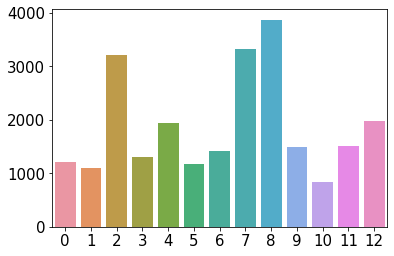

In [442]:
# new TF-IDF Vectorizer
cv_tfidf = TfidfVectorizer(stop_words=stopword_list,max_df=0.08,min_df=0.004)
# cv_tfidf = TfidfVectorizer(stop_words=stopword_list,max_df=0.6,min_df=0.005,ngram_range=(1, 2))
doc_word = cv_tfidf.fit_transform(df_news_clean['title_intro_clean'])

print(doc_word.shape)

# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(doc_word.transpose())

# We need to save a mapping (dict) of row id to word (token) for later use by gensim:
id2word = dict((v, k) for k, v in cv_tfidf.vocabulary_.items())

# Create lda model (equivalent to "fit" in sklearn)
lda = models.LdaMulticore(corpus=corpus, num_topics=13, id2word=id2word, passes=5, workers=1)

# Transform the docs from the word space to the topic space (like "transform" in sklearn)
lda_corpus = lda[corpus]

# Store the documents' topic vectors in a list so we can take a peak
lda_docs = [doc for doc in lda_corpus]

# View Topic Distribution
doc_cluster = [sorted(doc,key=lambda row:row[1])[::-1][0][0] for doc in lda_docs]
sns.barplot(x=pd.Series(doc_cluster).value_counts().keys(),y=pd.Series(doc_cluster).value_counts().values);

# # Check out the document vectors in the topic space for the first 5 documents
# lda_docs[:5]
lda.print_topics()

# #Save Trained Model
# with open('lda.pkl', 'wb') as picklefile:
#     pickle.dump(lda, picklefile)   

### Identify Topics from Model Output

In [673]:
topic_mapping={
                0:'Cryptocurrency Mining',
                1:'Tax Related',
                2:'Technology',
                3:'Binance - Biggest Crypto Trading Platform',
                4:'Market Analysis',
                5:'International - China and India',
                6:'Hackers/Stealing'  ,
                7:'Venezuela and Cryptocurrency', #Venezuela has hyperinflation with national currency. People ruf off to cryptos
                8:'Market',
                9:'Different Cryptocurrencies',
                10:'Satoshi Nakamoto',
                11:'Facebook',
                12:'Regulations'}

### Update df_news_clean Dataframe with Classified Topics and Pickle it

In [667]:
df_topics = []
for vec in vec_topics:
    sorted_x = sorted(vec, key=operator.itemgetter(1))
    sorted_x.reverse()
    df_topics.append(topic_mapping[sorted_x[0][0]])
with open('df_news_clean_topic.pkl','wb') as picklefile:
    pickle.dump(df_news_clean,picklefile)

In [796]:
list(df_news_clean_topic['topic'].value_counts().keys())

['Regulations',
 'Market',
 'Cryptocurrency Mining',
 'Tax Related',
 'Facebook',
 'Hackers/Stealing',
 'Market Analysis',
 'Different Cryptocurrencies',
 'Binance - Biggest Crypto Trading Platform',
 'Satoshi Nakamoto',
 'International - China and India',
 'Venezuela and Cryptocurrency',
 'Technology']

### Plot Topic Trends Over Time

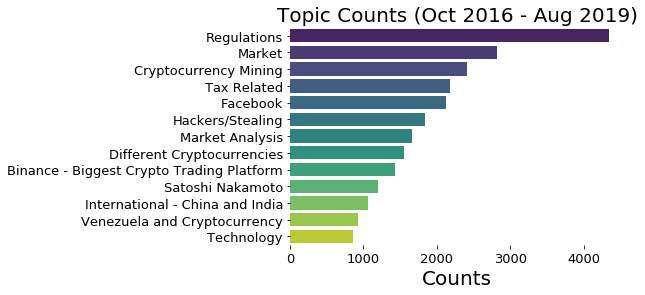

In [793]:
sns.barplot(y=df_news_clean_topic['topic'].value_counts().keys(),
            x=df_news_clean_topic['topic'].value_counts().values,
            palette="viridis")

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)
# Visualize Top 15 Publishers

#plt.axvline(x=930,color='r',linestyle ='-.' )  #vertical line. Linestype : ['-', '--', '-.', ':', '',]

#plt.ylabel('Publishers (n = 1563)')
#plt.yticks(rotation='vertical')
plt.xlabel('Counts')
plt.title('Topic Counts (Oct 2016 - Aug 2019)');

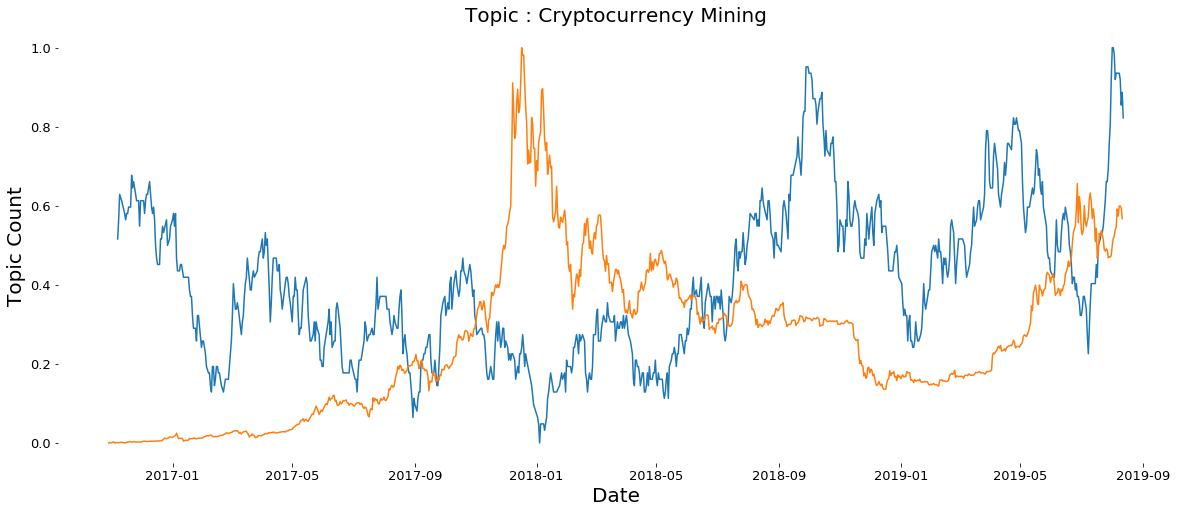

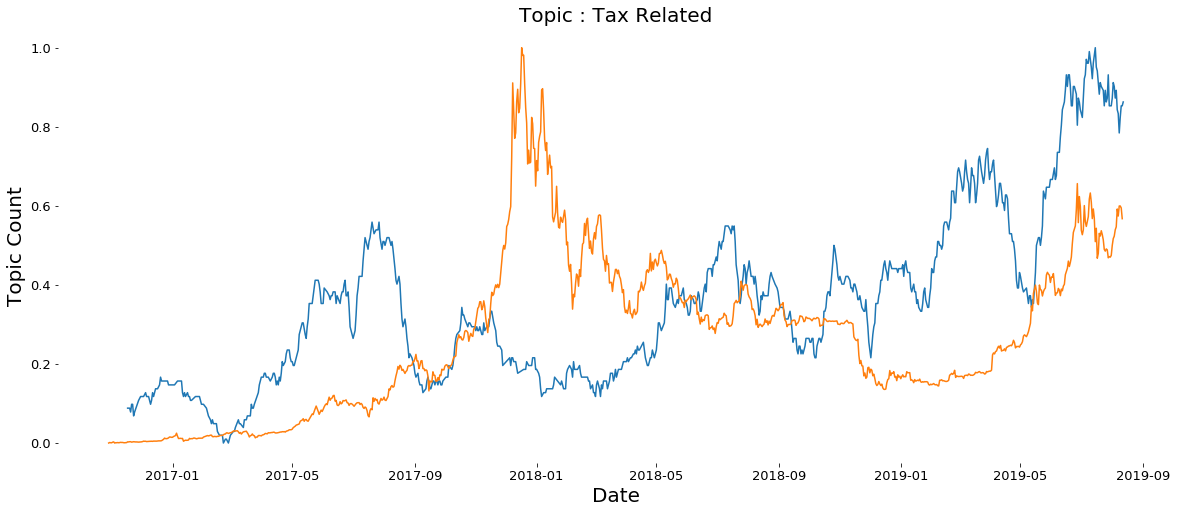

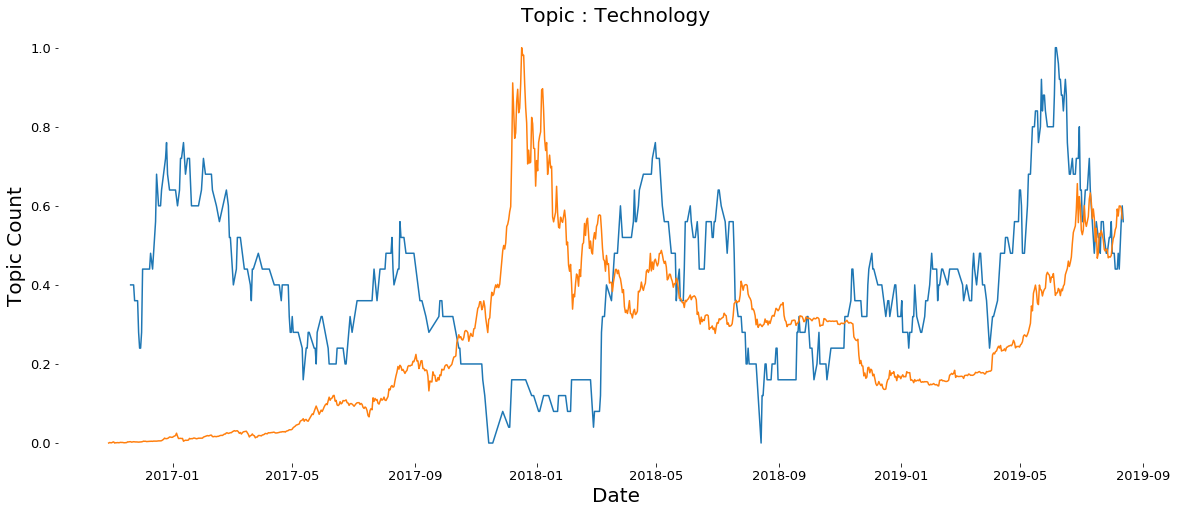

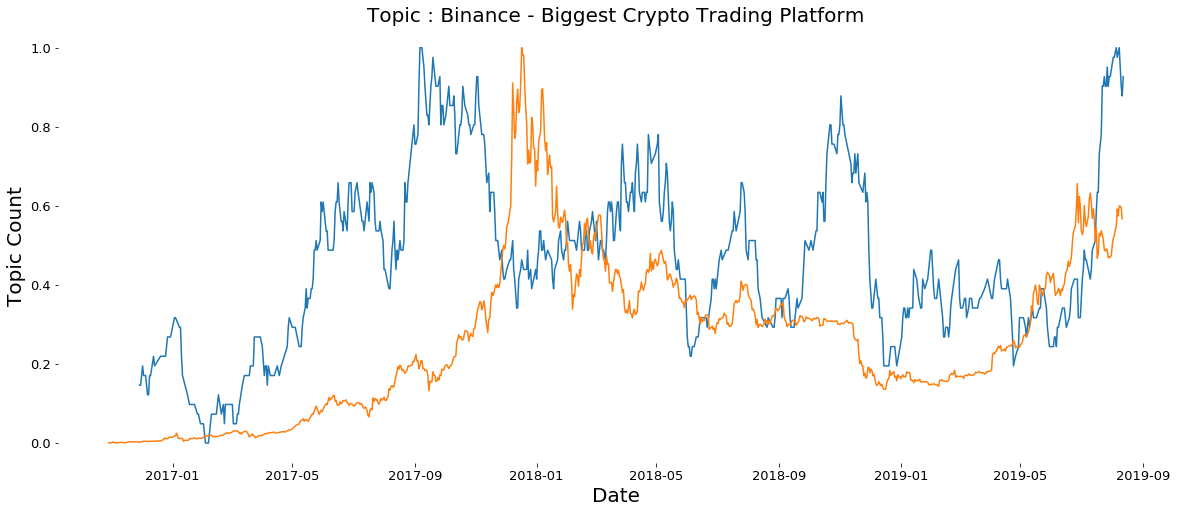

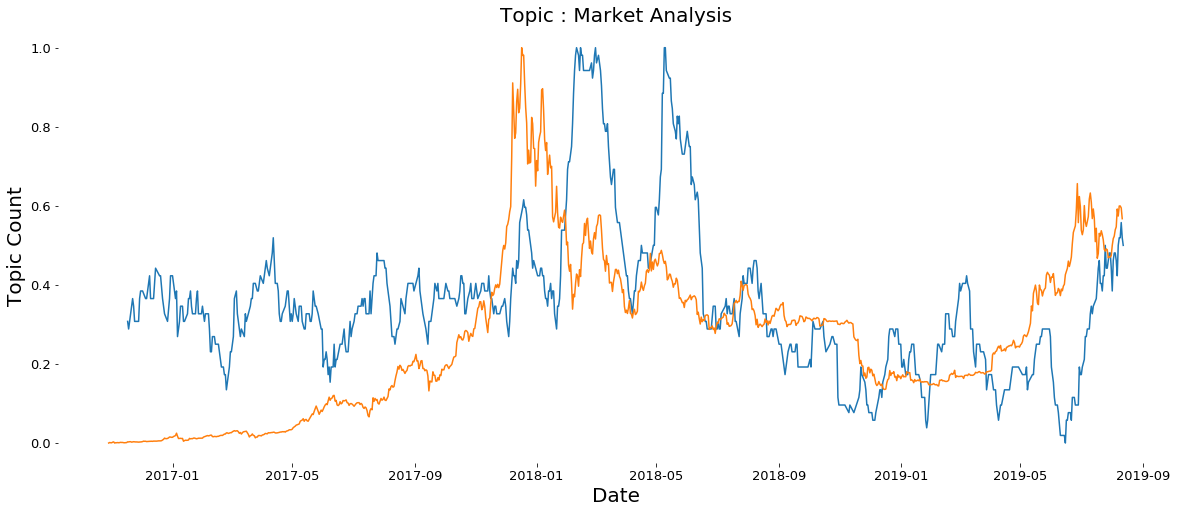

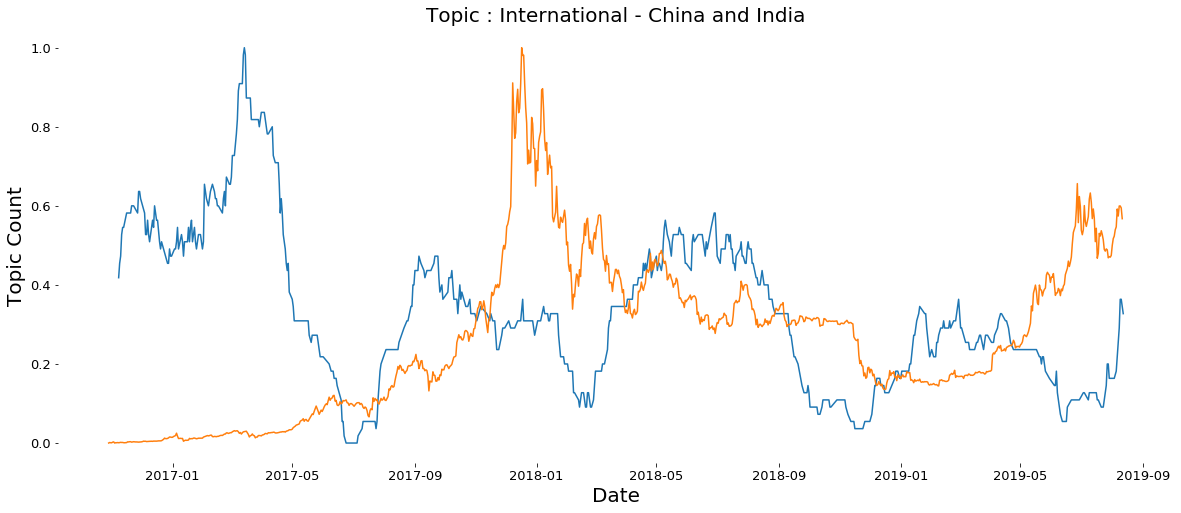

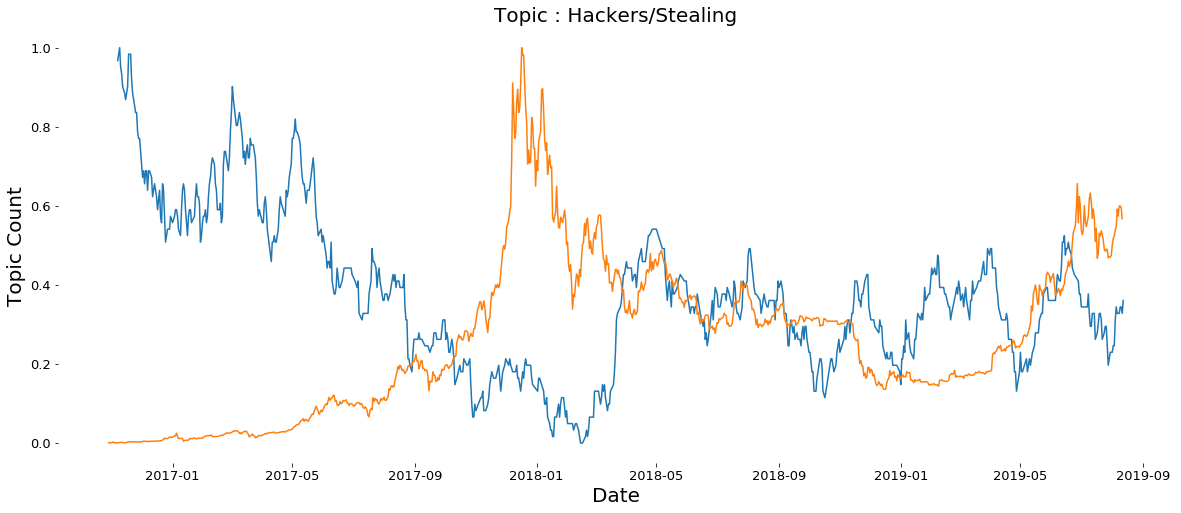

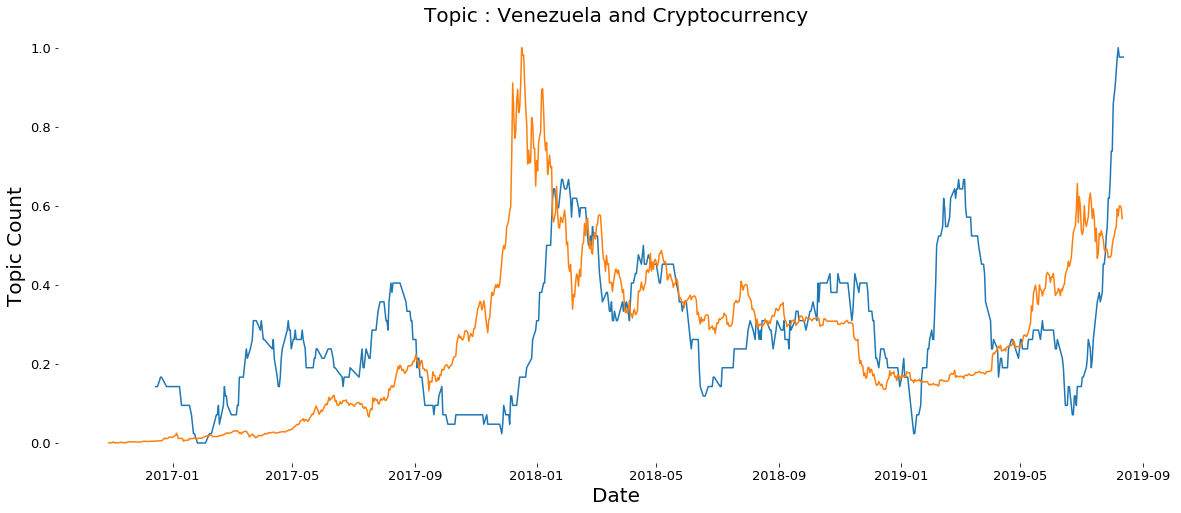

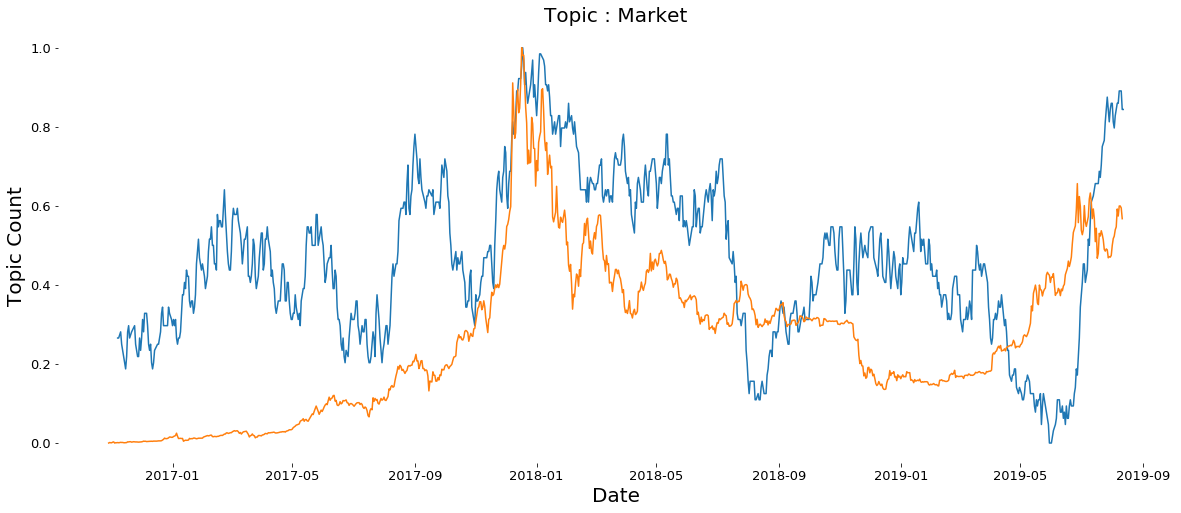

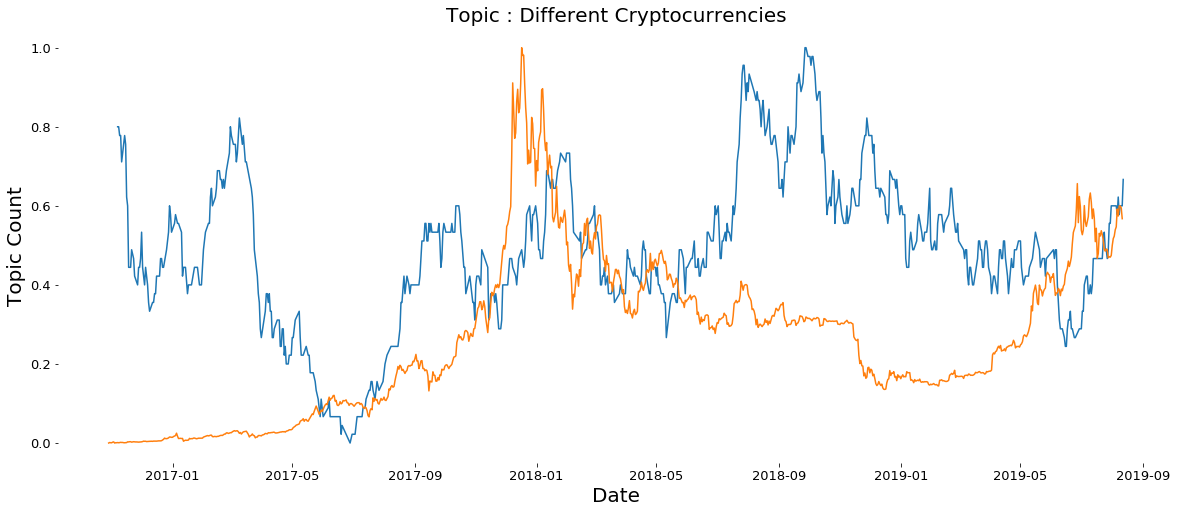

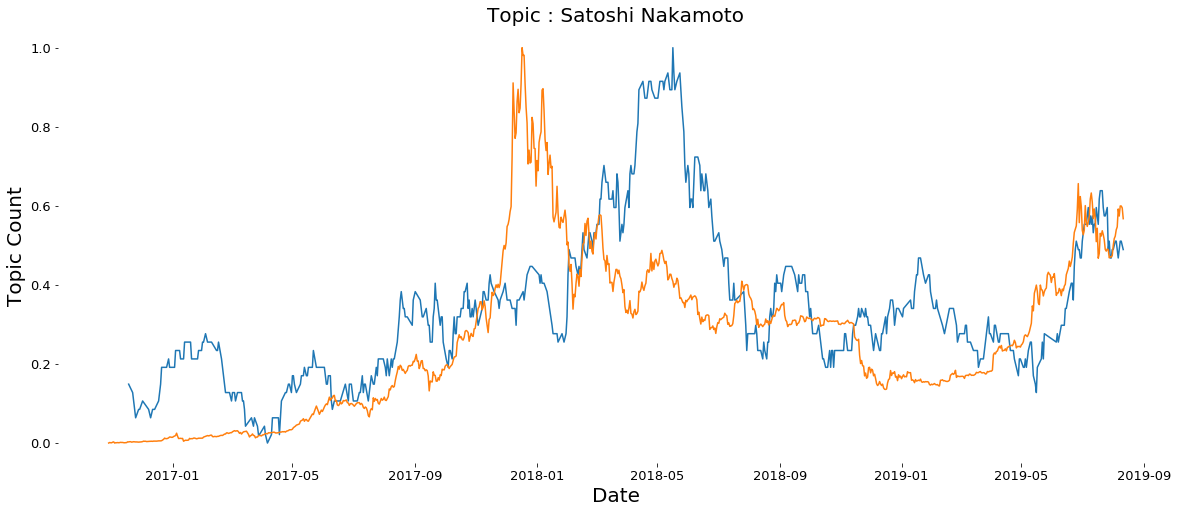

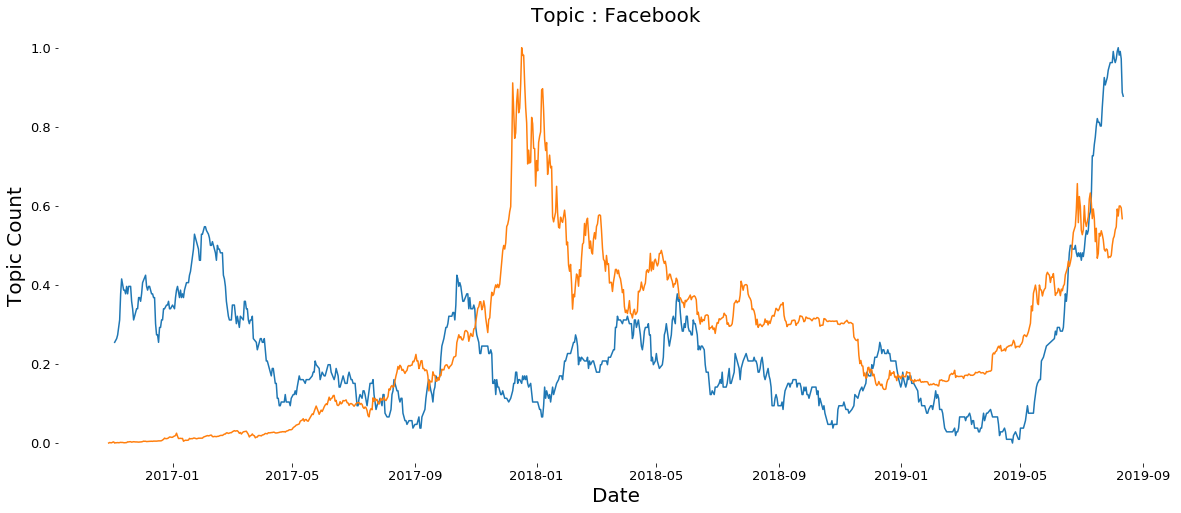

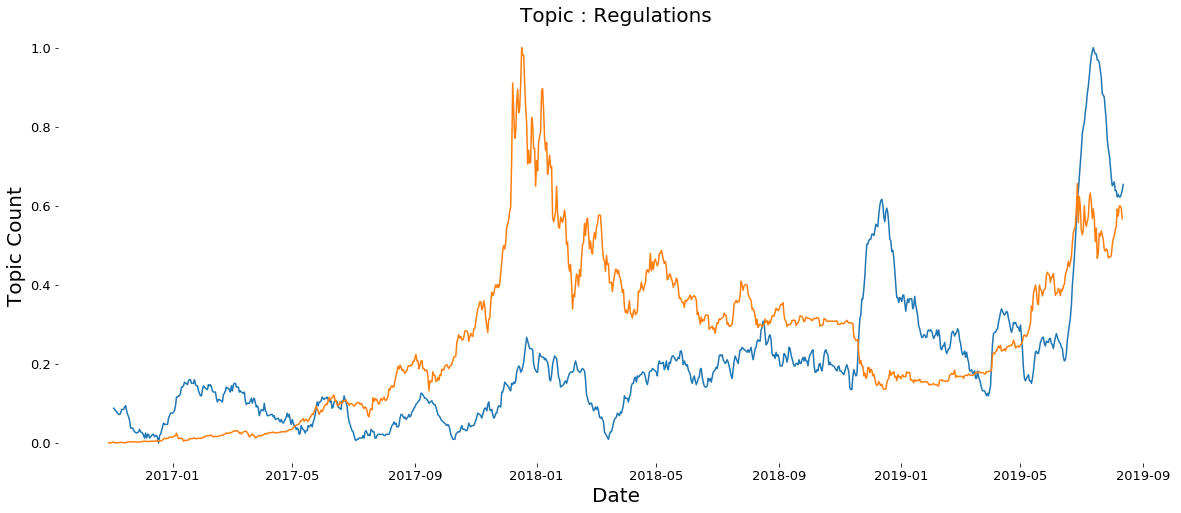

In [778]:
with open('df_news_clean_topic.pkl', 'rb') as picklefile: 
    df_news_clean_topic = pickle.load(picklefile)
    min_max_scaler = preprocessing.MinMaxScaler()
for topic in list(topic_mapping.values()):
    topic_df = df_news_clean_topic[df_news_clean_topic['topic']==topic].groupby(by=['date'],as_index=False).count()
    plt.figure(figsize=(20,8))
    sns.lineplot(x=topic_df['date'],y=min_max_scaler.fit_transform(np.array(topic_df['topic'].rolling(30).mean()).reshape(-1,1)).reshape(-1))
    sns.lineplot(x=df_daily['date'],y=min_max_scaler.fit_transform(df_daily['open'].values.reshape(-1,1)).reshape(-1))


    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)

    #plt.axvline(x=date(2018, 9, 1),color='r',linestyle ='-.' )  #vertical line. Linestype : ['-', '--', '-.', ':', '',]

    plt.xlabel('Date')
    plt.ylabel('Topic Count')
    plt.title('Topic : {}'.format(topic))
    plt.show() 
    


# Sentiment Analysis

## DataFrame Generation & Pickle Them

In [88]:
# Load df_news_clean
with open('df_news_clean.pkl', 'rb') as picklefile: 
    df_news_clean = pickle.load(picklefile)

# Replace stock specific terms for sentiment analysis
pos_list = ['rally', 'bounce', 'bullish', 'bull']
neg_list = ['bearish','bear','dip']

# Vader Sentiment Polarity
analyser = SentimentIntensityAnalyzer()
scores =[]
for article in df_news_clean['title_intro']:
    for word in pos_list:
        article=article.replace(word,'good')
    for word in neg_list:
        article=article.replace(word,'bad')
    score = analyser.polarity_scores(article)
    scores.append(score)
df_sentiment = pd.DataFrame(scores) # Convert sentiment scores to dataframe

# TextBlob Sentiment Polarity
scores =[]
for article in df_news_clean['title_intro']:
    for word in pos_list:
        article=article.replace(word,'good')
    for word in neg_list:
        article=article.replace(word,'bad')
    score = {'txtblob':np.round(TextBlob(article).sentiment.polarity,4)}
    scores.append(score)
df_sentiment_textblob = pd.DataFrame(scores) # Convert sentiment scores to dataframe

# Concat Vader and TextBlob Sentiment DataFrames
df_sentiment = pd.concat([df_sentiment,df_sentiment_textblob],axis=1)

# Concat news dataframe with sentiment dataframe & Create combine two sentiments
df_news_clean = pd.concat([df_news_clean,df_sentiment],axis=1)
df_news_clean['final_sentiment'] = (df_news_clean['compound']+df_news_clean['txtblob'])/2

with open('df_news_sentiment.pkl','wb') as picklefile:
    pickle.dump(df_news_clean,picklefile)

# Load df_news_clean
with open('df_news_sentiment.pkl', 'rb') as picklefile: 
    df_news_sentiment = pickle.load(picklefile)
    
# Scrape Bitcoin Price Table
start_date = min(df_news_sentiment['date']).strftime("%Y%m%d")
end_date = max(df_news_sentiment['date']).strftime("%Y%m%d")
df_price = scrape_bitcoin_price(start_date,end_date)

# get daily sentiment score by getting mean of sentiments & concat it with bitcoin price data
df_daily = df_news_sentiment.groupby(['date'], as_index=False).mean().copy()
df_daily = pd.concat([df_daily,df_price[['open', 'high', 'low', 'close', 'volume', 'market_cap']]],axis=1)

# Generate More Features
df_daily['percent_change_volume'] = (df_daily['volume'].shift(1)-df_daily['volume'])/df_daily['volume'].shift(1)
df_daily['percent_change_daily_open'] = (df_daily['open'].shift(1)-df_daily['open'])/df_daily['open'].shift(1)
df_daily['percent_change_wkly_open'] = (df_price['open'].rolling(7).mean().shift(1)-df_price['open'].rolling(7).mean())/df_price['open'].rolling(7).mean().shift(1)
df_daily['percent_change_monthly_open'] = (df_price['open'].rolling(28).mean().shift(1)-df_price['open'].rolling(28).mean())/df_price['open'].rolling(28).mean().shift(1)
df_daily['percent_change_daily_close'] = (df_daily['close'].shift(1)-df_daily['close'])/df_daily['close'].shift(1)
df_daily['percent_change_wkly_close'] = (df_price['close'].rolling(7).mean().shift(1)-df_price['close'].rolling(7).mean())/df_price['close'].rolling(7).mean().shift(1)
df_daily['daily_sentiment_change'] = (df_daily['final_sentiment'].shift(1)-df_daily['final_sentiment'])/df_daily['final_sentiment'].shift(1)
df_daily['wkly_sentiment_change'] = (df_daily['final_sentiment'].rolling(7).mean().shift(1)-df_daily['final_sentiment'].rolling(7).mean())/df_daily['final_sentiment'].rolling(7).mean().shift(1)
df_daily['2wk_sentiment_change'] = (df_daily['final_sentiment'].rolling(14).mean().shift(1)-df_daily['final_sentiment'].rolling(14).mean())/df_daily['final_sentiment'].rolling(14).mean().shift(1)
df_daily['3wk_sentiment_change'] = (df_daily['final_sentiment'].rolling(21).mean().shift(1)-df_daily['final_sentiment'].rolling(21).mean())/df_daily['final_sentiment'].rolling(21).mean().shift(1)
df_daily['4wk_sentiment_change'] = (df_daily['final_sentiment'].rolling(28).mean().shift(1)-df_daily['final_sentiment'].rolling(28).mean())/df_daily['final_sentiment'].rolling(28).mean().shift(1)
df_daily['target_daily'] = df_daily['percent_change_daily_open'].shift(-1)
df_daily.dropna(inplace=True)
df_daily.reset_index(drop=True,inplace=True)

# Pickle df_daily
with open('df_daily.pkl','wb') as picklefile:
    pickle.dump(df_daily,picklefile)

# Load df_news_clean
with open('df_daily.pkl', 'rb') as picklefile: 
    df_daily = pickle.load(picklefile)

## EDA Using Sentiments

### Sentiment vs Bitcoin Price Verification

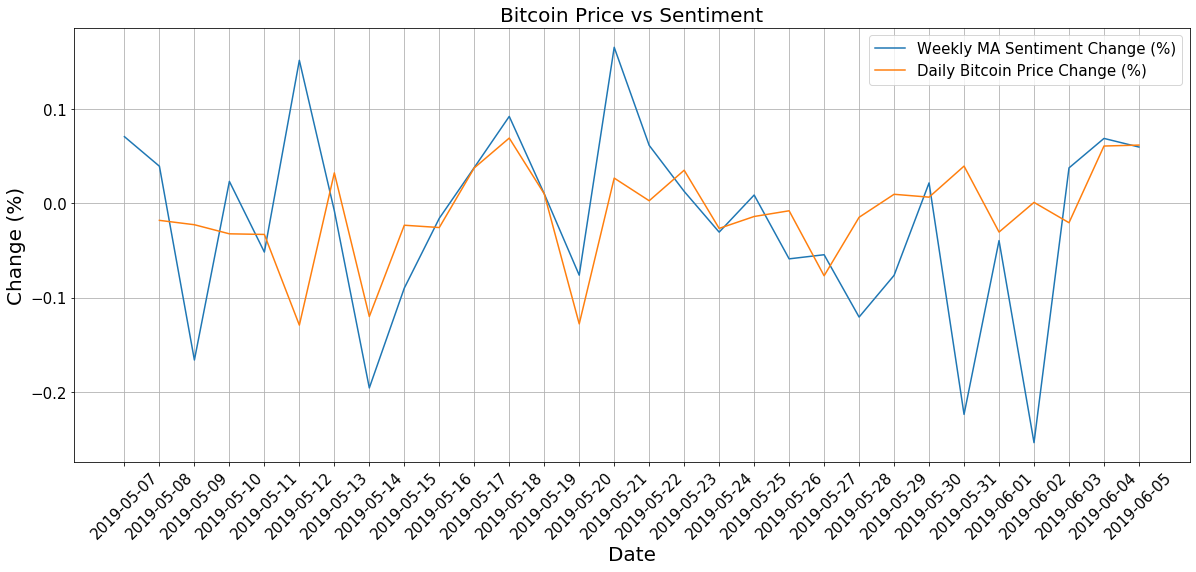

In [90]:
start_index = 920 #index of row where you want your start date to be
end_index = 950 #index of row where you want your start date to be

plt.figure(figsize=(20,8))
#sns.lineplot(x=df_daily['date'][start_index:end_index],y=df_daily['daily_sentiment_change'][start_index:end_index])
sns.lineplot(x=df_daily['date'][start_index:end_index],y=df_daily['wkly_sentiment_change'][start_index:end_index])
#sns.lineplot(x=df_daily['date'][start_index:end_index],y=df_daily['2wk_sentiment_change'][start_index:end_index])
sns.lineplot(x=df_daily['date'][start_index+1:end_index+1],y=df_daily['percent_change_daily_open'][start_index:end_index])

plt.xlabel('Date')
plt.ylabel('Change (%)')
plt.title('Bitcoin Price vs Sentiment')
plt.legend(['Weekly MA Sentiment Change (%)','Daily Bitcoin Price Change (%)'])
plt.xticks(df_daily['date'][start_index:end_index],rotation=45)
plt.grid()

### Sentiment Differences

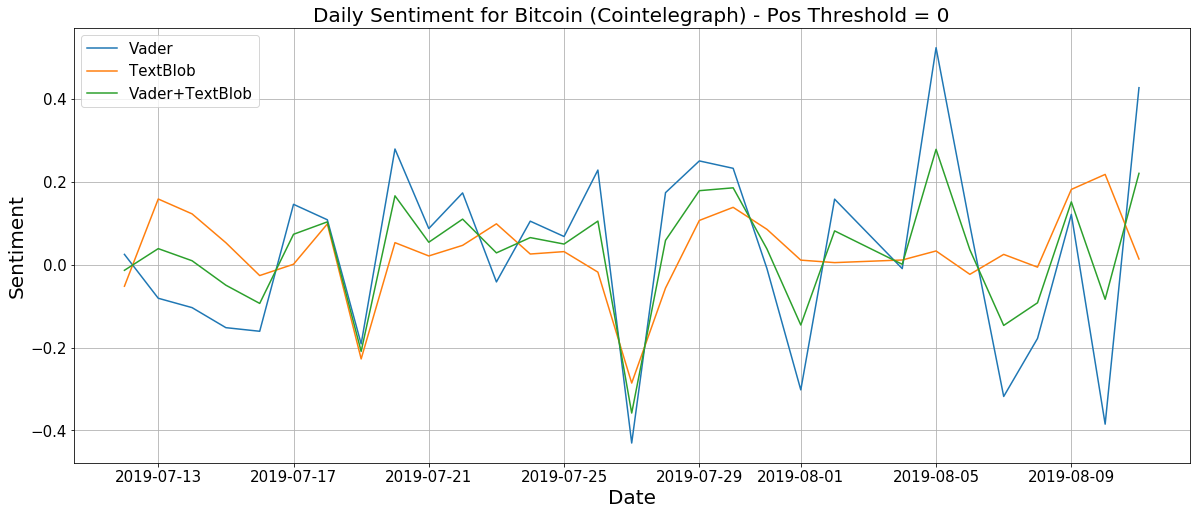

In [91]:
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 40
positive_sentiment_threshold=0

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
publisher = top_5_publishers[0]
# Generate DataFrame for daily sentiment for each publisher
sentiment_by_publisher = df_news_sentiment.groupby(by=['date','publisher'],as_index=False).mean()

sentiment_publisher_1 = sentiment_by_publisher[sentiment_by_publisher['publisher']==publisher]
sentiment_publisher_1 = sentiment_publisher_1.merge(df_daily[['date','daily_sentiment_change','target_daily']], left_on='date', right_on='date')

sentiment_publisher_1['vader_buy_sell'] = sentiment_publisher_1['compound'].apply(lambda x: 1 if x>positive_sentiment_threshold else 0).copy()
sentiment_publisher_1['vader_profit'] = (sentiment_publisher_1['vader_buy_sell']*100*sentiment_publisher_1['target_daily']).copy()

sentiment_publisher_1['txtblob_buy_sell'] = sentiment_publisher_1['txtblob'].apply(lambda x: 1 if x>positive_sentiment_threshold else 0).copy()
sentiment_publisher_1['txtblob_profit'] = (sentiment_publisher_1['txtblob_buy_sell']*100*sentiment_publisher_1['target_daily']).copy()

sentiment_publisher_1['compound_buy_sell'] = sentiment_publisher_1['final_sentiment'].apply(lambda x: 1 if x>positive_sentiment_threshold else 0).copy()
sentiment_publisher_1['compound_profit'] = (sentiment_publisher_1['compound_buy_sell']*100*sentiment_publisher_1['target_daily']).copy()

sentiment_publisher_1['compound_change_buy_sell'] = sentiment_publisher_1['daily_sentiment_change'].apply(lambda x: 1 if x>positive_sentiment_threshold else 0).copy()
sentiment_publisher_1['compound_change_profit'] = (sentiment_publisher_1['compound_change_buy_sell']*100*sentiment_publisher_1['target_daily']).copy()

sentiment_publisher_1.dropna(inplace=True)

start_index = len(sentiment_publisher_1)-30
end_index = len(sentiment_publisher_1)

plt.figure(figsize=(20,8))
sns.lineplot(x=sentiment_publisher_1['date'][start_index:end_index],y=sentiment_publisher_1['compound'][start_index:end_index])
sns.lineplot(x=sentiment_publisher_1['date'][start_index:end_index],y=sentiment_publisher_1['txtblob'][start_index:end_index])
sns.lineplot(x=sentiment_publisher_1['date'][start_index:end_index],y=sentiment_publisher_1['final_sentiment'][start_index:end_index])

plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.title('Daily Sentiment for Bitcoin ({}) - Pos Threshold = {}'.format(publisher,positive_sentiment_threshold))
plt.legend(['Vader','TextBlob','Vader+TextBlob'])
#     plt.xticks(sentiment_publisher_1['date'][start_index:end_index],rotation=60)
plt.grid()
plt.show()

### Article Selection

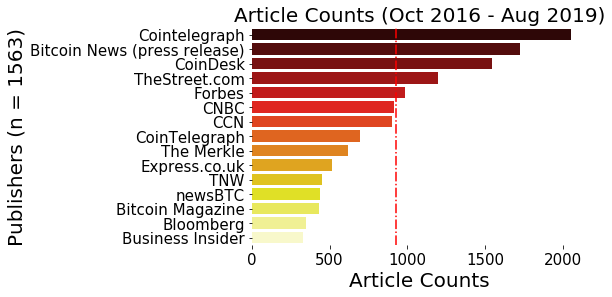

In [773]:
sns.barplot(y=df_news_sentiment['publisher'].value_counts()[0:15].keys(),
            x=df_news_sentiment['publisher'].value_counts()[0:15].values,
            palette="hot")

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)
# Visualize Top 15 Publishers

plt.axvline(x=930,color='r',linestyle ='-.' )  #vertical line. Linestype : ['-', '--', '-.', ':', '',]

plt.ylabel('Publishers (n = 1563)')
#plt.yticks(rotation='vertical')
plt.xlabel('Article Counts')
plt.title('Article Counts (Oct 2016 - Aug 2019)');

# Obtain top 5 publisher names
top_5_publishers = list(df_news_sentiment['publisher'].value_counts()[0:5].index)

### Profit Graphs

In [ ]:
# # GIF images generation for each publisher
# publisher = top_5_publishers[2]
# length = len([sentiment_by_publisher['publisher']==publisher])
# for i in trange(int(np.sum(sentiment_by_publisher['publisher']==publisher)/10)):
#     graph_sentiment_profit_gif(publisher,0,date(2015,6,8),i)

# # GIF images generation with cumulative sentiments
# length = len(df_news_sentiment.groupby(by=['date'],as_index=False).mean())
# for i in trange(int(np.sum(length)/10)):
#     graph_sentiment_profit_gif('all',0,date(2018,3,20),i)

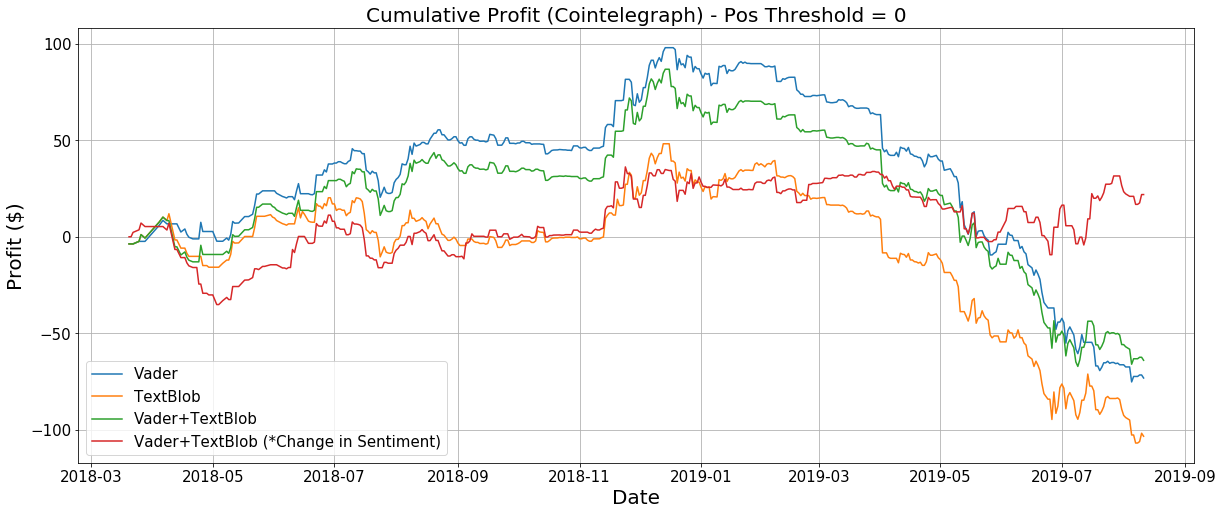

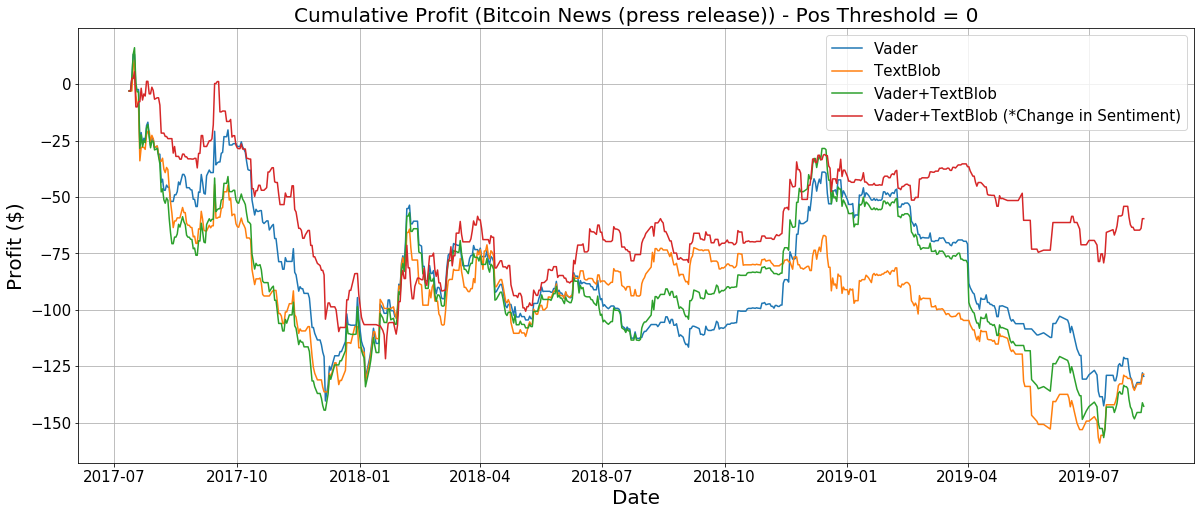

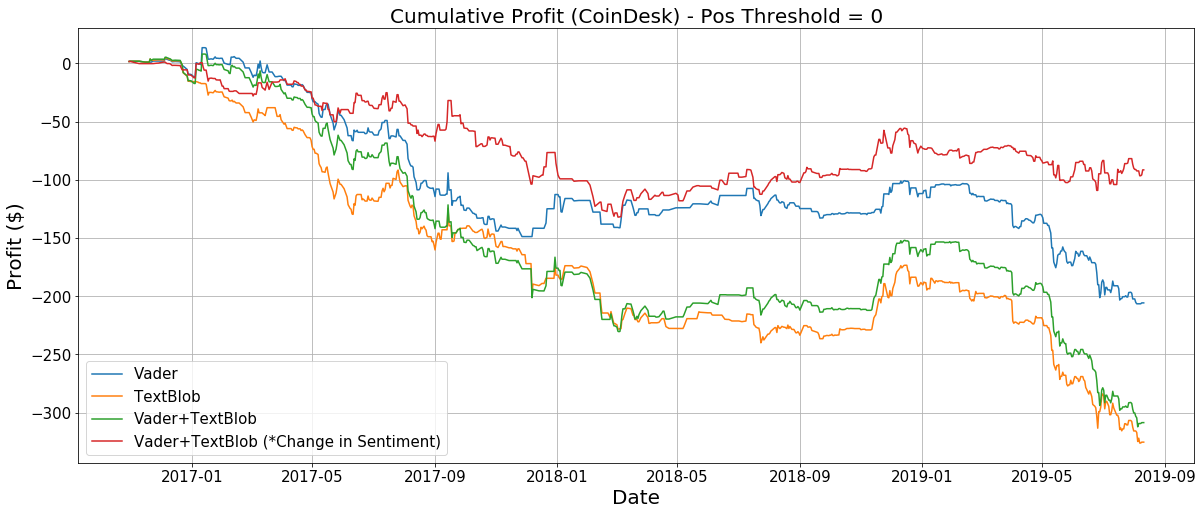

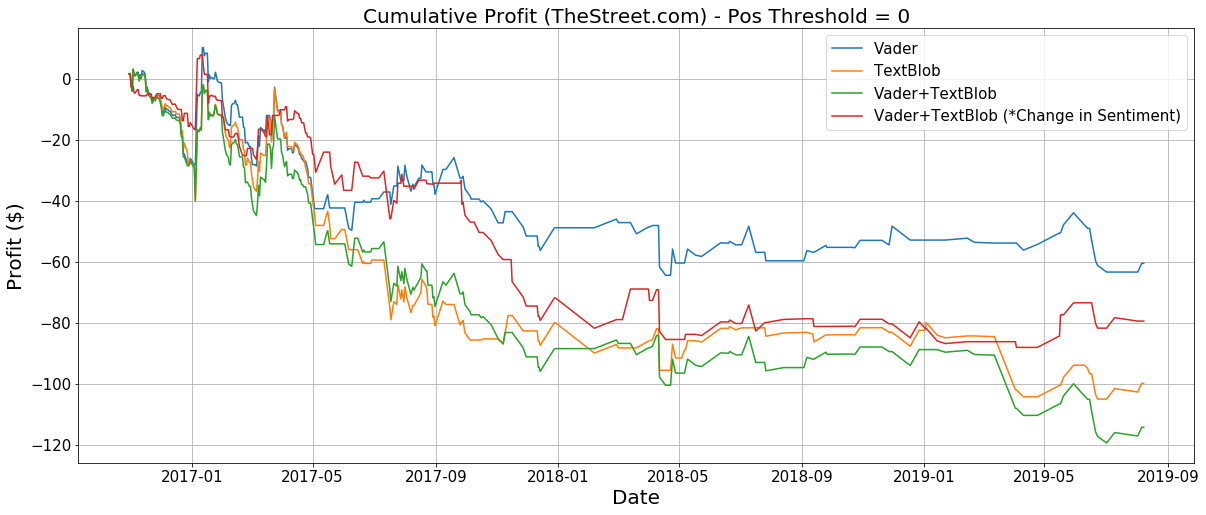

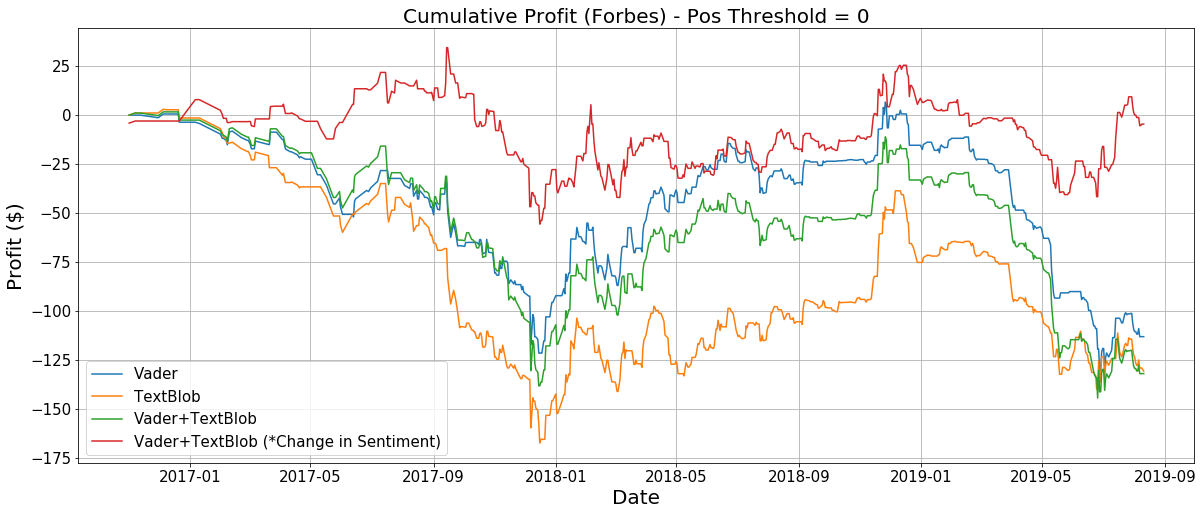

In [92]:
for publisher in top_5_publishers:
    graph_sentiment_profit(publisher,0,date(2015,6,8))

Almost always using combination of Vader+TextBlob with using change in sentiment performed better than using raw sentiment scores

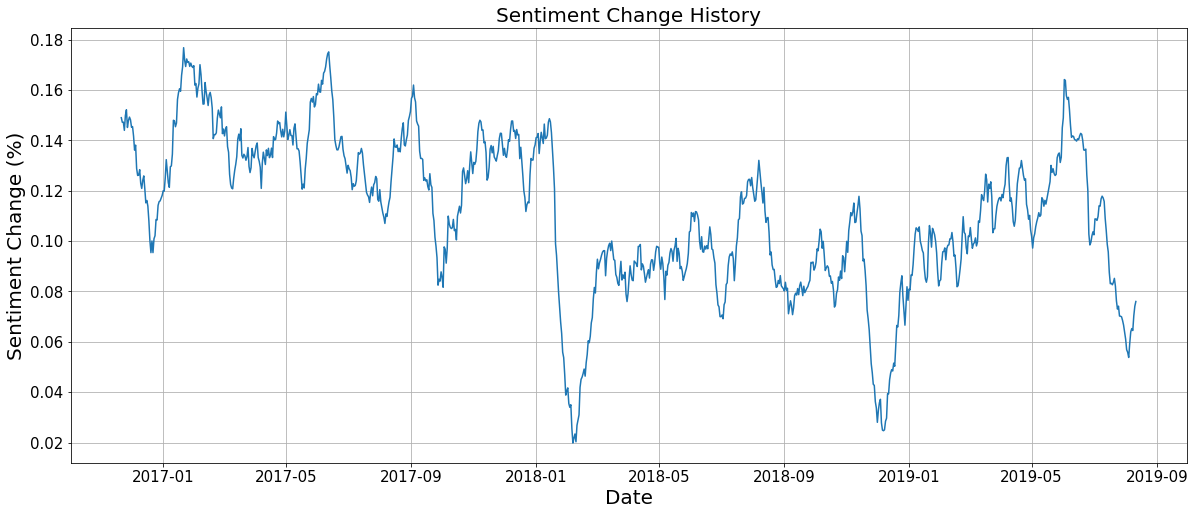

In [93]:
plt.figure(figsize=(20,8))
sns.lineplot(x=df_daily['date'],y=df_daily['final_sentiment'].rolling(24).mean())
# sns.lineplot(x=df_daily['date'],y=df_daily['wkly_sentiment_change'])
# sns.lineplot(x=df_daily['date'],y=df_daily['2wk_sentiment_change'])


plt.xlabel('Date')
plt.ylabel('Sentiment Change (%)')
plt.title('Sentiment Change History')
# plt.legend(['Daily Sentiment Change (%)','Weekly MA Sentiment Change (%)','Daily Bitcoin Price Change (%)'])
plt.grid()

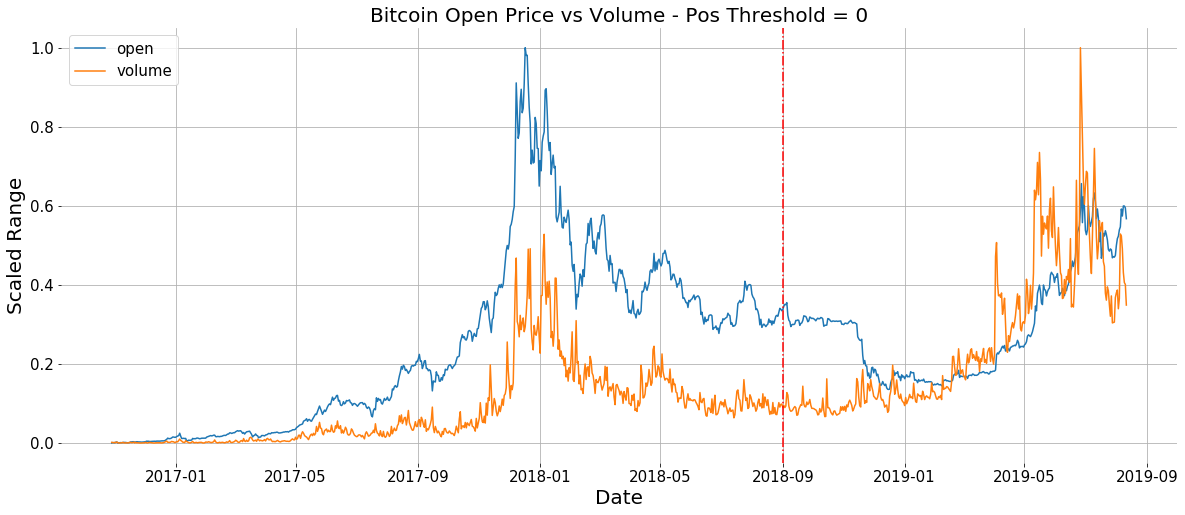

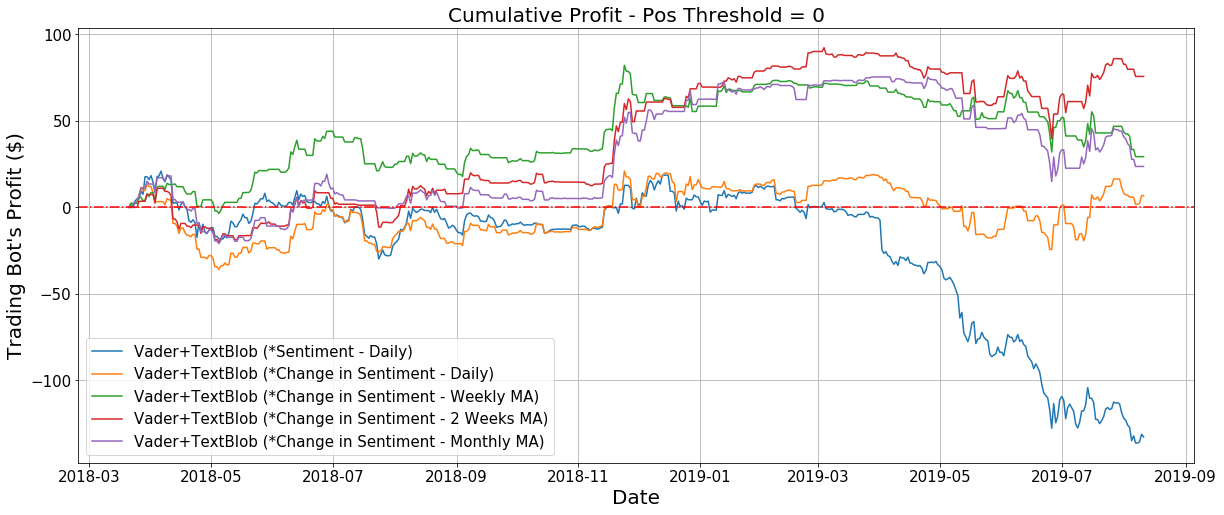

In [855]:
graph_sentiment_profit('all',0,date(2018, 3,20))

Text(0.5, 1.0, 'Raw Sentiment Distribution')

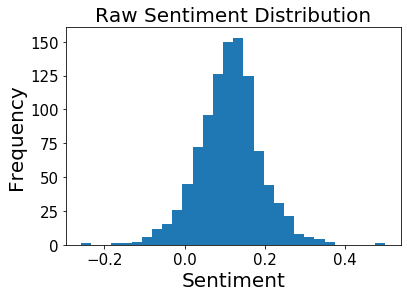

In [95]:
# Compound sentiment distribution
plt.hist(df_daily['final_sentiment'],bins=30)
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Raw Sentiment Distribution')

In [867]:
thresholds,raw_senti,senti_change_daily,senti_change_weekly,senti_change_2wk,senti_change_monthly = best_threshold(0,0.4,0.001,date(2015, 9, 1),date(2018, 3, 20))


100%|██████████| 400/400 [00:15<00:00, 21.32it/s]


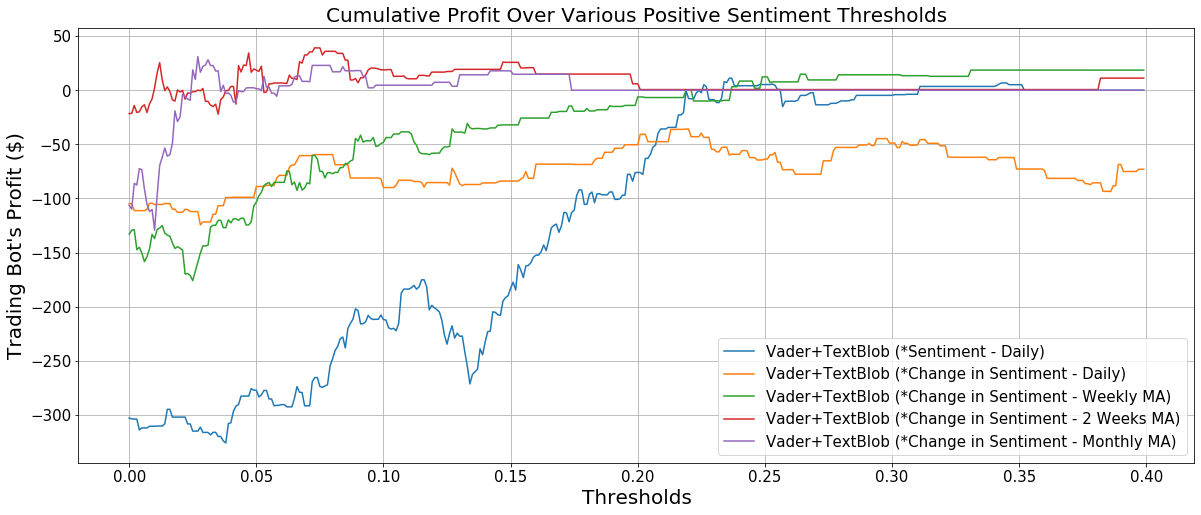

In [868]:
model_list = [raw_senti,senti_change_daily,senti_change_weekly,senti_change_2wk,senti_change_monthly]
threshold_vs_profit(thresholds,model_list)

In [872]:
print("Raw : ",thresholds[np.argmax(raw_senti)] )
print("Daily : ",thresholds[np.argmax(senti_change_daily)] )
print("Weekly : ",thresholds[np.argmax(senti_change_weekly)] )
print("Bieekly : ",thresholds[np.argmax(senti_change_2wk)] )
print("Monthly : ",thresholds[np.argmax(senti_change_monthly)] )

Raw :  0.23600000000000002
Daily :  0.219
Weekly :  0.331
Bieekly :  0.073
Monthly :  0.027


# Bitcoin Price Prediction

## Simple NN

### View Heatmap of Features to Target

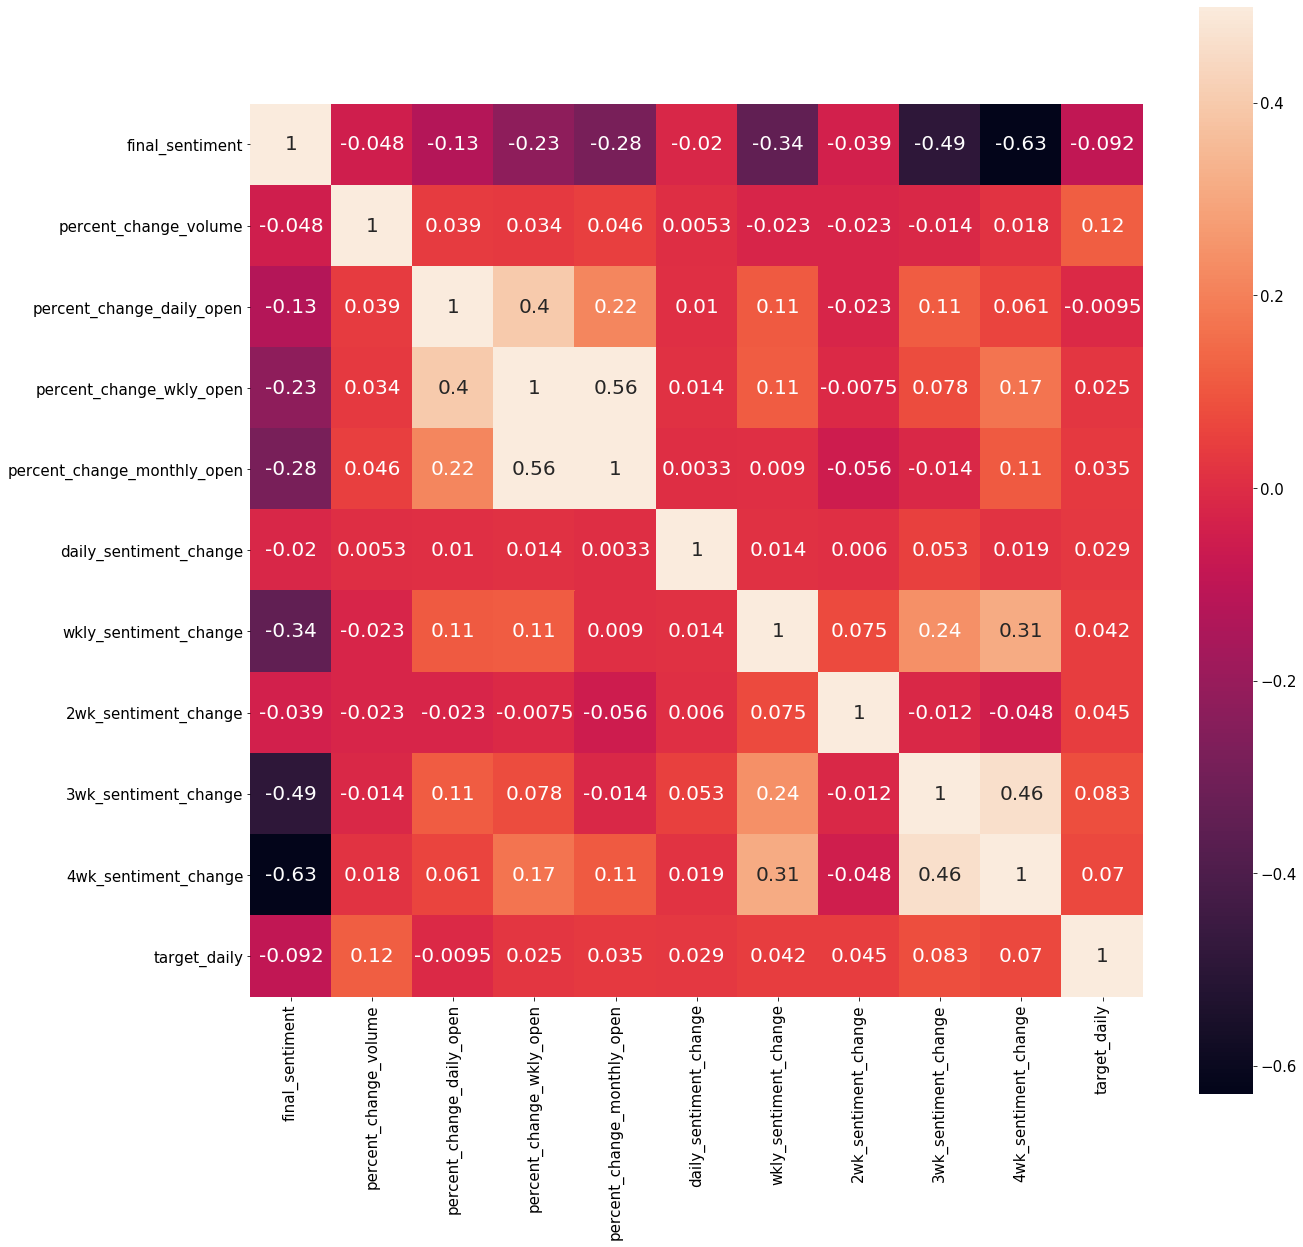

In [190]:
# # Drop unneeded columns
# df_daily.drop(columns=['neg', 'neu', 'pos', 'compound', 'txtblob','high','low','market_cap','open', 'close', 'volume','percent_change_daily_close', 'percent_change_wkly_close'],inplace=True)

# View Hitmap
C_mat = df_daily.corr()
fig = plt.figure(figsize=(20,20))
sns.heatmap(C_mat,vmax=0.5,square=True,annot=True)
plt.show()

### Add LDA Topic Probability Featurs

In [449]:
from gensim.corpora import Dictionary
dic = Dictionary([df_news_clean['title_intro_clean']])
vec_bows=[]
for ix,item in enumerate(corpus):
    vec_bows.append(item)

vec_lda_topics=[lda[vec_bow] for vec_bow in vec_bows]

lda_vector = []
for id,vec_lda_topic in enumerate(vec_lda_topics):
    lda_vector.append(vec_lda_topic)
    
num_topic = 13
lda_topic_vectors = []
for vector in lda_vector:
    empty_dict = {x:0 for x in range(num_topic)}
    for topic in vector:            
        empty_dict[topic[0]]=topic[1]
    lda_topic_vectors.append(list(empty_dict.values()))
    
# Create DF of lda topic vectors and turn it groupby date
df_lda = pd.DataFrame(lda_topic_vectors)
df_lda['date'] = df_news_sentiment['date']
df_lda_daily = df_lda.groupby(by=['date'],as_index=False,).mean()

# Merge lda vector to main dataframe
df_daily = df_daily.merge(df_lda_daily, left_on='date', right_on='date')

### Split Data & Apply StandardScaler

In [612]:
min_date = date(2017,6,1)
max_date = date(2019,7,1)

mask_train = ((df_daily['date']>min_date) & (df_daily['date']<(max_date- timedelta(days=2))))
mask_test = (df_daily['date'] > max_date) 

features = ['percent_change_volume'
            ,'percent_change_daily_open'
#            ,'percent_change_wkly_open'
            #,'percent_change_monthly_open'
            ,'daily_sentiment_change'
#            ,'wkly_sentiment_change'
            #,'2wk_sentiment_change'
            #,'4wk_sentiment_change'
#             ,0
#             ,1
#             ,2
#             ,3
#             ,4
#             ,5
#             ,6
#             ,7
#             ,8
#             ,9
#             ,'10_y'
#             ,'11_y'
#             ,'12_y'
           ]
target = ['target_daily']

df_train = df_daily[mask_train].dropna().copy() 
df_test =  df_daily[mask_test].dropna().copy()

X_train = df_train[features]
y_train = df_train[target]

X_test = df_test[features]
y_test = df_test[target]


# Split train into train & val for NN training. shuffle=False so that it doesn't look into the future
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.1,shuffle=False)

# Perform Scaling on Train Data and Apply to Val and Test Set
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
print("Holdout set percentage : {} %".format(len(X_test)/(len(X_train)+len(X_val)+len(X_test))*100))

Holdout set percentage : 6.269113149847094 %


### Define and Train NN

In [615]:
# Model
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization,Input
from keras.optimizers import Adam

# Initialize Model
nn = Sequential()
# Input layer & hidden layer
nn.add(Dense(3, input_shape=(X_train.shape[1],), activation='relu'))
#nn.add(Dropout(0.5))
# nn.add(Dense(4,activation='relu'))
# nn.add(Dropout(0.2))
# Output layer
nn.add(Dense(1))
# Compile the architecture and view summary
optimizer = Adam(lr=0.01)
nn.compile(optimizer=optimizer, loss='mean_squared_error')
#nn.summary()

from keras.callbacks import ModelCheckpoint,EarlyStopping

# Early Stopping for the nn
early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto',restore_best_weights=True)
callbacks_list = [early_stopping]

# Train the model
nn.fit(x=X_train,y=y_train.values, epochs=70,shuffle=True,
          validation_data=(X_val, y_val.values),callbacks=callbacks_list)# validation_split=0.2)#) #, callbacks=callbacks_list)
model_pred = nn.predict(X_test)

# # Save Trained Model
# with open('nn.pkl', 'wb') as picklefile:
#     pickle.dump(nn, picklefile)    


Train on 551 samples, validate on 62 samples
Epoch 1/70
551/551 [==============================] - 5s 9ms/step - loss: 0.2146 - val_loss: 0.0351
Epoch 2/70
551/551 [==============================] - 0s 152us/step - loss: 0.0826 - val_loss: 0.0307
Epoch 3/70
551/551 [==============================] - 0s 182us/step - loss: 0.0491 - val_loss: 0.0196
Epoch 4/70
551/551 [==============================] - 0s 177us/step - loss: 0.0344 - val_loss: 0.0135
Epoch 5/70
551/551 [==============================] - 0s 181us/step - loss: 0.0217 - val_loss: 0.0126
Epoch 6/70
551/551 [==============================] - 0s 179us/step - loss: 0.0144 - val_loss: 0.0127
Epoch 7/70
551/551 [==============================] - 0s 185us/step - loss: 0.0101 - val_loss: 0.0090
Epoch 8/70
551/551 [==============================] - 0s 171us/step - loss: 0.0074 - val_loss: 0.0077
Epoch 9/70
551/551 [==============================] - 0s 186us/step - loss: 0.0055 - val_loss: 0.0061
Epoch 10/70
551/551 [==================

Profit : $20.809261162270108


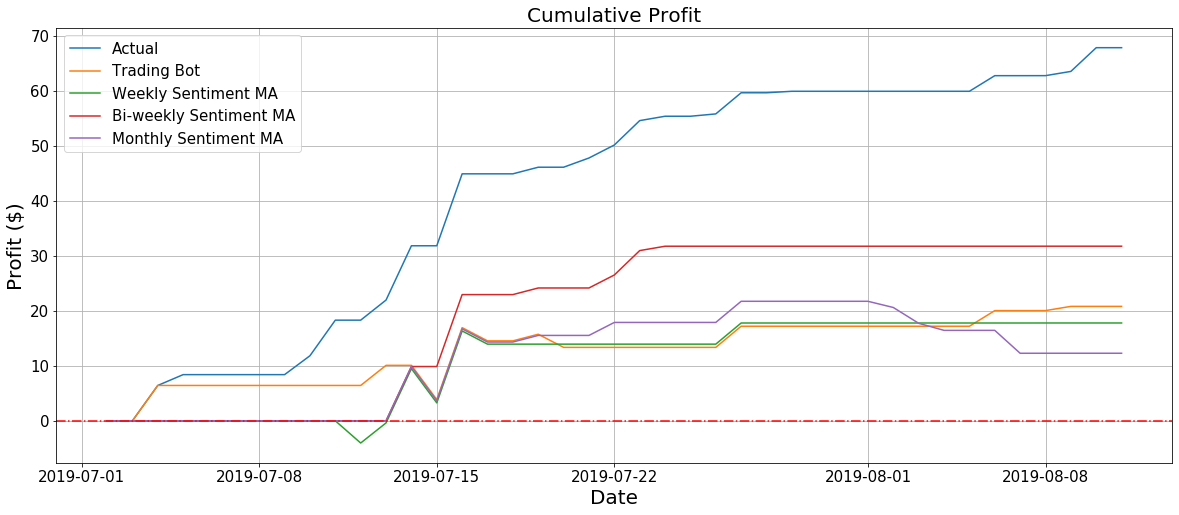

In [616]:
# Predict from July, Shuffle=True since i'm using only daily data.
model_profit_graph(model_pred,min_date,max_date)

Profit : $20.809261162270108


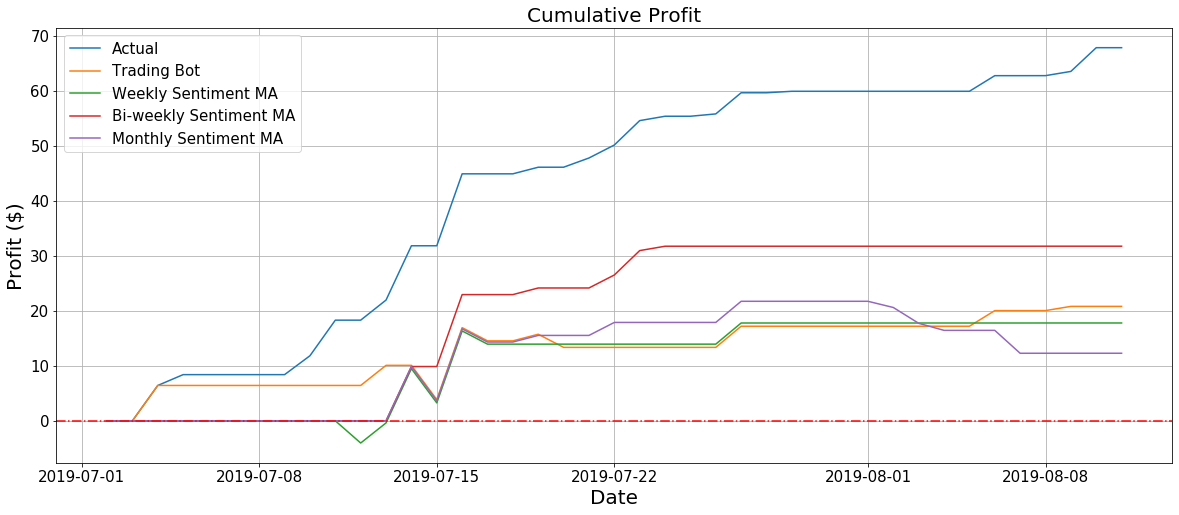

In [883]:
# Predict from July, Shuffle=True since i'm using only daily data.
model_profit_graph(model_pred,min_date,max_date)

## LSTM

### Split Data

In [ ]:
# Parameters for train/test split
min_date = date(2014,6,1)
max_date = date(2019,3,1)
date_gap = 8
max_max_date = date(2020,1,1)
train_cols = [
              'final_sentiment','open','high', 'low', 'close', 'volume','market_cap',
             'percent_change_volume','percent_change_daily_close','daily_sentiment_change',
              'percent_change_wkly_close','wkly_sentiment_change'
             ]
x_train, x_test, scaler = custom_train_test_split(df_daily,train_cols,date_gap, min_date,max_date,max_max_date )

# Parameters for processing data for LSTM input
BATCH_SIZE = 8 # Small batch_size increase train time and too big batch size reduce model's ability to generalize, but quicker
TIME_STEPS = 28 # how far it looks back
y_col_index = np.where(np.array(train_cols) == 'close')[0][0]

x_t, y_t = build_timeseries(x_train, TIME_STEPS, y_col_index)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
x_temp, y_temp = build_timeseries(x_test,TIME_STEPS, y_col_index)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

### Define and Train LSTM

In [296]:
# Start LSTM Model & Train
lstm_model = create_model(0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=0, mode='auto',restore_best_weights=True)
callbacks_list = [early_stopping]

history = lstm_model.fit(x_t, y_t, epochs=200, verbose=2, batch_size=BATCH_SIZE,
                    shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                    trim_dataset(y_val, BATCH_SIZE)), callbacks=callbacks_list)

Train and Test size 845 175



length of time-series i/o (817, 28, 12) (817,)



length of time-series i/o (147, 28, 12) (147,)
Train on 816 samples, validate on 72 samples
Epoch 1/200
 - 12s - loss: 0.0658 - val_loss: 0.0248
Epoch 2/200
 - 1s - loss: 0.0124 - val_loss: 0.0248
Epoch 3/200
 - 1s - loss: 0.0069 - val_loss: 0.0127
Epoch 4/200
 - 1s - loss: 0.0054 - val_loss: 0.0093
Epoch 5/200
 - 1s - loss: 0.0045 - val_loss: 0.0054
Epoch 6/200
 - 1s - loss: 0.0041 - val_loss: 0.0039
Epoch 7/200
 - 1s - loss: 0.0038 - val_loss: 0.0054
Epoch 8/200
 - 1s - loss: 0.0034 - val_loss: 0.0050
Epoch 9/200
 - 1s - loss: 0.0030 - val_loss: 0.0036
Epoch 10/200
 - 1s - loss: 0.0028 - val_loss: 0.0036
Epoch 11/200
 - 1s - loss: 0.0027 - val_loss: 0.0040
Epoch 12/200
 - 1s - loss: 0.0025 - val_loss: 0.0036
Epoch 13/200
 - 1s - loss: 0.0024 - val_loss: 0.0036
Epoch 14/200
 - 1s - loss: 0.0022 - val_loss: 0.0041
Epoch 15/200
 - 1s - loss: 0.0020 - val_loss: 0.0020
Epoch 16/200
 - 1s - loss: 0.0021 - val_loss: 0.0027
Epoch 17/200
 - 1s - loss: 0.0021 - val_loss: 0.0022
Epoch 18/200
 

### Visualize LSTM Model Output

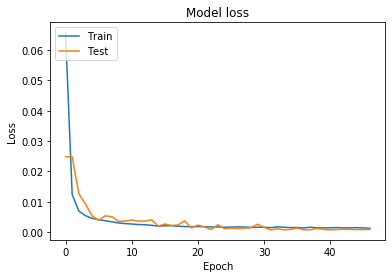

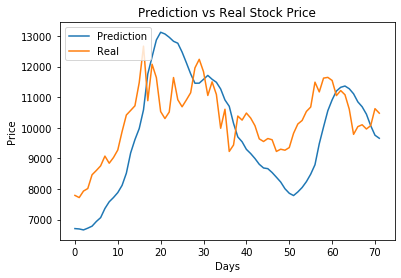

In [297]:
# Visualize the training data
from matplotlib import pyplot as plt
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
#plt.show()
#plt.savefig(os.path.join(git_folder_location, 'train_vis_BS_'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))

# load the saved best model from above
# saved_model = load_model(os.path.join(git_folder_location, 'best_model.h5')) # , "lstm_best_7-3-19_12AM",
# print(saved_model)

y_pred = lstm_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
# error = mean_squared_error(y_test_t, y_pred)
# print("Error is", error, y_pred.shape, y_test_t.shape)
# print(y_pred[0:15])
# print(y_test_t[0:15])
y_pred_org = (y_pred * scaler.data_range_[3]) + scaler.data_min_[3] # scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * scaler.data_range_[3]) + scaler.data_min_[3] # scaler.inverse_transform(y_test_t)
# print(y_pred_org[0:15])
# print(y_test_t_org[0:15])

# Visualize the prediction
from matplotlib import pyplot as plt
plt.figure()
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
#plt.show()
#plt.savefig(os.path.join(git_folder_location, 'pred_vs_real_BS'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))
#print_time("program completed ", stime)
# No sentiment